In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 64

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([Flatten()(output) for output in layer_outputs[-3:]])
    x = BatchNormalization()(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 64)    384         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 16000, 64)    256         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16000, 64)    0           batch_normalization_v1[0][0]     
_____________________________________

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 64)    384         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_9 (Batch (None, 16000, 64)    256         conv1d_7[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 64)    0           batch_normalization_v1_9[0][0]   
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 64)    384         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_22 (Batc (None, 16000, 64)    256         conv1d_18[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 64)    0           batch_normalization_v1_22[0][0]  
__________________________________________________________________________________________________
max_poolin

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 6.6511 - acc: 0.3697
Epoch 00001: val_loss improved from inf to 5.58645, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_BN_3_conv_checkpoint/001-5.5865.hdf5
36805/36805 [==============================] - 68s 2ms/sample - loss: 6.6515 - acc: 0.3697 - val_loss: 5.5865 - val_acc: 0.4284
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.8794 - acc: 0.5726
Epoch 00002: val_loss did not improve from 5.58645
36805/36805 [==============================] - 63s 2ms/sample - loss: 4.8796 - acc: 0.5726 - val_loss: 5.6055 - val_acc: 0.5143
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.1778 - acc: 0.6433
Epoch 00003: val_loss did not improve from 5.58645
36805/36805 [==============================] - 63s 2ms/sample - loss: 4.1786 - acc: 0.6432 - val_loss: 5.7

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6661 - acc: 0.8803
Epoch 00028: val_loss did not improve from 5.13491
36805/36805 [==============================] - 63s 2ms/sample - loss: 1.6668 - acc: 0.8802 - val_loss: 5.3866 - val_acc: 0.6196
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5164 - acc: 0.8913
Epoch 00029: val_loss did not improve from 5.13491
36805/36805 [==============================] - 63s 2ms/sample - loss: 1.5167 - acc: 0.8913 - val_loss: 5.1409 - val_acc: 0.6352
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5098 - acc: 0.8919
Epoch 00030: val_loss did not improve from 5.13491
36805/36805 [==============================] - 63s 2ms/sample - loss: 1.5105 - acc: 0.8918 - val_loss: 5.3811 - val_acc: 0.6233
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4853 - acc: 0.8938
Epoch 00031: val_loss did not improve from 5.13491
36805/36805 [===========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1112 - acc: 0.9230
Epoch 00057: val_loss did not improve from 5.07245
36805/36805 [==============================] - 63s 2ms/sample - loss: 1.1110 - acc: 0.9230 - val_loss: 5.2548 - val_acc: 0.6403
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0710 - acc: 0.9274
Epoch 00058: val_loss did not improve from 5.07245
36805/36805 [==============================] - 63s 2ms/sample - loss: 1.0713 - acc: 0.9274 - val_loss: 5.2509 - val_acc: 0.6420
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1179 - acc: 0.9229
Epoch 00059: val_loss did not improve from 5.07245
36805/36805 [==============================] - 63s 2ms/sample - loss: 1.1182 - acc: 0.9228 - val_loss: 5.1759 - val_acc: 0.6527
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0901 - acc: 0.9251
Epoch 00060: val_loss did not improve from 5.07245
36805/36805 [===========

Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9200 - acc: 0.9386
Epoch 00086: val_loss did not improve from 4.91546
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.9207 - acc: 0.9385 - val_loss: 5.9387 - val_acc: 0.6028
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9184 - acc: 0.9379
Epoch 00087: val_loss did not improve from 4.91546
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.9191 - acc: 0.9379 - val_loss: 5.2387 - val_acc: 0.6501
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9253 - acc: 0.9375
Epoch 00088: val_loss did not improve from 4.91546
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.9256 - acc: 0.9375 - val_loss: 5.5810 - val_acc: 0.6287
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9197 - acc: 0.9383
Epoch 00089: val_loss did not improve from 4.91546
36805/36805 [===========

Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8450 - acc: 0.9435
Epoch 00116: val_loss did not improve from 4.91546
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.8449 - acc: 0.9435 - val_loss: 5.1265 - val_acc: 0.6594
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8117 - acc: 0.9469
Epoch 00117: val_loss did not improve from 4.91546
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.8120 - acc: 0.9469 - val_loss: 5.2971 - val_acc: 0.6452
Epoch 118/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8046 - acc: 0.9464
Epoch 00118: val_loss did not improve from 4.91546
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.8045 - acc: 0.9464 - val_loss: 5.1843 - val_acc: 0.6553
Epoch 119/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8159 - acc: 0.9457
Epoch 00119: val_loss did not improve from 4.91546
36805/36805 [=======

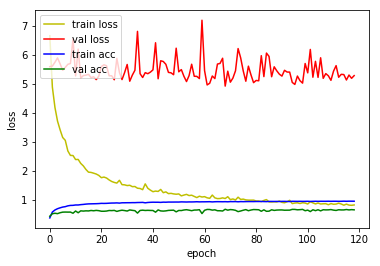

4815/4815 [==============================] - 3s 686us/sample - loss: 5.5172 - acc: 0.6268
Loss: 5.517237427078675 Accuracy: 0.6267913

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5853 - acc: 0.4571
Epoch 00001: val_loss improved from inf to 2.18174, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_BN_4_conv_checkpoint/001-2.1817.hdf5
36805/36805 [==============================] - 60s 2ms/sample - loss: 2.5854 - acc: 0.4571 - val_loss: 2.1817 - val_acc: 0.4647
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2000 - acc: 0.7256
Epoch 00002: val_loss did not improve from 2.18174
36805/36805 [==============================] - 56s 2ms/sample - loss: 1.1999 - acc: 0.7256 - val_loss: 2.5820 - val_acc: 0.5304
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6715 - acc: 0.8406
Epoch 00003: val_loss did not improve from 2.18174
36805/36805 [======

Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1245 - acc: 0.9796
Epoch 00030: val_loss did not improve from 2.18174
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.1245 - acc: 0.9796 - val_loss: 3.7880 - val_acc: 0.6177
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1068 - acc: 0.9829
Epoch 00031: val_loss did not improve from 2.18174
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.1068 - acc: 0.9829 - val_loss: 3.7424 - val_acc: 0.6259
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1201 - acc: 0.9812
Epoch 00032: val_loss did not improve from 2.18174
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.1203 - acc: 0.9812 - val_loss: 4.0043 - val_acc: 0.6000
Epoch 33/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1161 - acc: 0.9818
Epoch 00033: val_loss did not improve from 2.18174
36805/36805 [===========

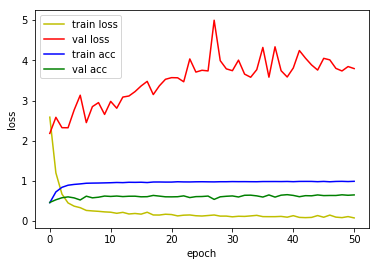

4815/4815 [==============================] - 3s 638us/sample - loss: 2.3505 - acc: 0.4444
Loss: 2.350521321311547 Accuracy: 0.44444445

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8009 - acc: 0.5028
Epoch 00001: val_loss improved from inf to 1.52066, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_BN_5_conv_checkpoint/001-1.5207.hdf5
36805/36805 [==============================] - 62s 2ms/sample - loss: 1.8008 - acc: 0.5028 - val_loss: 1.5207 - val_acc: 0.5351
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9718 - acc: 0.7227
Epoch 00002: val_loss improved from 1.52066 to 1.28679, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_BN_5_conv_checkpoint/002-1.2868.hdf5
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.9718 - acc: 0.7227 - val_loss: 1.2868 - val_acc: 0.6462
Epoch 3/500
36800/36805 [============================>.] - ET

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0541 - acc: 0.9870
Epoch 00029: val_loss did not improve from 1.13776
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0541 - acc: 0.9870 - val_loss: 1.6841 - val_acc: 0.7209
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0413 - acc: 0.9917
Epoch 00030: val_loss did not improve from 1.13776
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0421 - acc: 0.9916 - val_loss: 1.7651 - val_acc: 0.7205
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0736 - acc: 0.9820
Epoch 00031: val_loss did not improve from 1.13776
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0736 - acc: 0.9820 - val_loss: 1.8222 - val_acc: 0.7214
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0359 - acc: 0.9930
Epoch 00032: val_loss did not improve from 1.13776
36805/36805 [===========

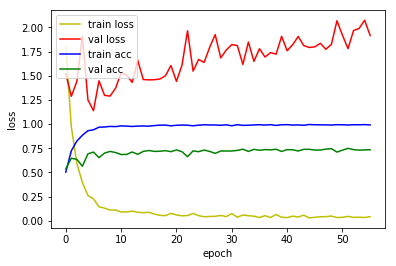

4815/4815 [==============================] - 3s 684us/sample - loss: 1.2836 - acc: 0.6746
Loss: 1.2835506092350801 Accuracy: 0.6745587

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5931 - acc: 0.5233
Epoch 00001: val_loss improved from inf to 1.39215, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_BN_6_conv_checkpoint/001-1.3922.hdf5
36805/36805 [==============================] - 67s 2ms/sample - loss: 1.5931 - acc: 0.5233 - val_loss: 1.3922 - val_acc: 0.5628
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9361 - acc: 0.7249
Epoch 00002: val_loss improved from 1.39215 to 1.00847, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_BN_6_conv_checkpoint/002-1.0085.hdf5
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.9361 - acc: 0.7248 - val_loss: 1.0085 - val_acc: 0.7114
Epoch 3/500
36800/36805 [============================>.] - ET

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0438 - acc: 0.9896
Epoch 00027: val_loss did not improve from 0.50037
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0438 - acc: 0.9896 - val_loss: 0.5512 - val_acc: 0.8763
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0258 - acc: 0.9957
Epoch 00028: val_loss did not improve from 0.50037
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0261 - acc: 0.9956 - val_loss: 0.6078 - val_acc: 0.8642
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0578 - acc: 0.9858
Epoch 00029: val_loss did not improve from 0.50037
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0579 - acc: 0.9857 - val_loss: 0.5695 - val_acc: 0.8770
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0306 - acc: 0.9940
Epoch 00030: val_loss did not improve from 0.50037
36805/36805 [===========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0305 - acc: 0.9930
Epoch 00057: val_loss did not improve from 0.50037
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0308 - acc: 0.9930 - val_loss: 0.7020 - val_acc: 0.8744
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0174 - acc: 0.9962
Epoch 00058: val_loss did not improve from 0.50037
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0175 - acc: 0.9962 - val_loss: 0.6392 - val_acc: 0.8779
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0213 - acc: 0.9949
Epoch 00059: val_loss did not improve from 0.50037
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0213 - acc: 0.9949 - val_loss: 0.6907 - val_acc: 0.8763
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0167 - acc: 0.9966
Epoch 00060: val_loss did not improve from 0.50037
36805/36805 [===========

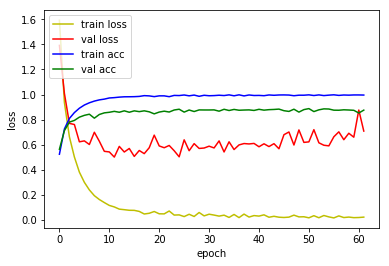

4815/4815 [==============================] - 4s 744us/sample - loss: 0.5836 - acc: 0.8459
Loss: 0.5835922305457688 Accuracy: 0.8458982

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4875 - acc: 0.5496
Epoch 00001: val_loss improved from inf to 1.24950, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_BN_7_conv_checkpoint/001-1.2495.hdf5
36805/36805 [==============================] - 73s 2ms/sample - loss: 1.4875 - acc: 0.5495 - val_loss: 1.2495 - val_acc: 0.5993
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7549 - acc: 0.7784
Epoch 00002: val_loss improved from 1.24950 to 0.67897, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_BN_7_conv_checkpoint/002-0.6790.hdf5
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.7552 - acc: 0.7784 - val_loss: 0.6790 - val_acc: 0.7973
Epoch 3/500
36800/36805 [============================>.] - ET

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0299 - acc: 0.9926
Epoch 00026: val_loss did not improve from 0.27381
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0299 - acc: 0.9926 - val_loss: 0.2903 - val_acc: 0.9350
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0181 - acc: 0.9962
Epoch 00027: val_loss did not improve from 0.27381
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0181 - acc: 0.9963 - val_loss: 0.3275 - val_acc: 0.9266
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0135 - acc: 0.9974
Epoch 00028: val_loss did not improve from 0.27381
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0135 - acc: 0.9974 - val_loss: 0.3389 - val_acc: 0.9222
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0206 - acc: 0.9953
Epoch 00029: val_loss did not improve from 0.27381
36805/36805 [===========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0099 - acc: 0.9976
Epoch 00056: val_loss did not improve from 0.27381
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0099 - acc: 0.9976 - val_loss: 0.3854 - val_acc: 0.9248
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0072 - acc: 0.9983
Epoch 00057: val_loss did not improve from 0.27381
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0072 - acc: 0.9983 - val_loss: 0.2872 - val_acc: 0.9404
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0133 - acc: 0.9963
Epoch 00058: val_loss did not improve from 0.27381
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0133 - acc: 0.9963 - val_loss: 0.3168 - val_acc: 0.9378
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0042 - acc: 0.9992
Epoch 00059: val_loss did not improve from 0.27381
36805/36805 [===========

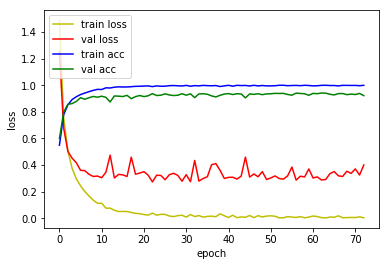

4815/4815 [==============================] - 4s 758us/sample - loss: 0.3127 - acc: 0.9161
Loss: 0.31269655174741123 Accuracy: 0.91609555

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3525 - acc: 0.5899
Epoch 00001: val_loss improved from inf to 0.99449, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_BN_8_conv_checkpoint/001-0.9945.hdf5
36805/36805 [==============================] - 77s 2ms/sample - loss: 1.3524 - acc: 0.5899 - val_loss: 0.9945 - val_acc: 0.6986
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5757 - acc: 0.8304
Epoch 00002: val_loss improved from 0.99449 to 0.45314, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_BN_8_conv_checkpoint/002-0.4531.hdf5
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.5758 - acc: 0.8304 - val_loss: 0.4531 - val_acc: 0.8684
Epoch 3/500
36800/36805 [============================>.] - 

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0110 - acc: 0.9982
Epoch 00026: val_loss did not improve from 0.19672
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0110 - acc: 0.9982 - val_loss: 0.2133 - val_acc: 0.9471
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0134 - acc: 0.9975
Epoch 00027: val_loss did not improve from 0.19672
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0134 - acc: 0.9975 - val_loss: 0.2398 - val_acc: 0.9453
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0144 - acc: 0.9969
Epoch 00028: val_loss did not improve from 0.19672
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0144 - acc: 0.9969 - val_loss: 0.2104 - val_acc: 0.9478
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0191 - acc: 0.9953
Epoch 00029: val_loss did not improve from 0.19672
36805/36805 [===========

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0034 - acc: 0.9995
Epoch 00055: val_loss did not improve from 0.18570
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0034 - acc: 0.9995 - val_loss: 0.1929 - val_acc: 0.9606
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0059 - acc: 0.9986
Epoch 00056: val_loss did not improve from 0.18570
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0059 - acc: 0.9986 - val_loss: 0.2234 - val_acc: 0.9581
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0092 - acc: 0.9974
Epoch 00057: val_loss did not improve from 0.18570
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0092 - acc: 0.9974 - val_loss: 0.2135 - val_acc: 0.9541
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0074 - acc: 0.9979
Epoch 00058: val_loss did not improve from 0.18570
36805/36805 [===========

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0027 - acc: 0.9995
Epoch 00085: val_loss did not improve from 0.18570
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0027 - acc: 0.9995 - val_loss: 0.2069 - val_acc: 0.9562
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0035 - acc: 0.9989
Epoch 00086: val_loss did not improve from 0.18570
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0036 - acc: 0.9989 - val_loss: 0.2256 - val_acc: 0.9550
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0080 - acc: 0.9979
Epoch 00087: val_loss did not improve from 0.18570
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0080 - acc: 0.9979 - val_loss: 0.2189 - val_acc: 0.9550
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0047 - acc: 0.9988
Epoch 00088: val_loss did not improve from 0.18570
36805/36805 [===========

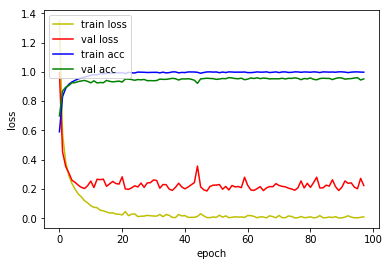

4815/4815 [==============================] - 4s 776us/sample - loss: 0.2438 - acc: 0.9425
Loss: 0.2438399968372884 Accuracy: 0.94247144



In [10]:
base = '1D_CNN_custom_multi_3_concat_BN'

for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_3_concat_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_3_concat_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 64)    384         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_39 (Batc (None, 16000, 64)    256         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 64)    0           batch_normalization_v1_39[0][0]  
_______________________________________________________________

4815/4815 [==============================] - 4s 801us/sample - loss: 2.3505 - acc: 0.4444
Loss: 2.350521321311547 Accuracy: 0.44444445

1D_CNN_custom_multi_3_concat_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 64)    384         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_48 (Batc (None, 16000, 64)    256         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activation) 

4815/4815 [==============================] - 4s 843us/sample - loss: 0.5836 - acc: 0.8459
Loss: 0.5835922305457688 Accuracy: 0.8458982

1D_CNN_custom_multi_3_concat_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 64)    384         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_61 (Batc (None, 16000, 64)    256         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activation) 

4815/4815 [==============================] - 4s 928us/sample - loss: 0.2438 - acc: 0.9425
Loss: 0.2438399968372884 Accuracy: 0.94247144


In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_BN_2'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_3_concat_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 64)    384         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_39 (Batc (None, 16000, 64)    256         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 64)    0           batch_normalization_v1_39[0][0]  
_______________________________________________________________

4815/4815 [==============================] - 4s 911us/sample - loss: 4.2760 - acc: 0.6066
Loss: 4.276038798513442 Accuracy: 0.6066459

1D_CNN_custom_multi_3_concat_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 64)    384         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_48 (Batc (None, 16000, 64)    256         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activation)  

4815/4815 [==============================] - 5s 935us/sample - loss: 0.8073 - acc: 0.8511
Loss: 0.8073117482699338 Accuracy: 0.8510904

1D_CNN_custom_multi_3_concat_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 64)    384         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_61 (Batc (None, 16000, 64)    256         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activation) 

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2766 - acc: 0.9439
Loss: 0.27661314223955125 Accuracy: 0.94392526
